# Part 3, finall version - RNN, LSTM, GRU 

In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data import DataLoader

from src import *

## Create dataloader, example

In [2]:
dataloader = CSVDataLoader('data/MSFT_2006-01-01_to_2018-01-01.csv')
X_train_1, X_test_1 = dataloader.split_by_year([2006, 2007], [2008])

training_dataset_1 = StockTorchDataset(X_train_1, zscore_params=None, history=5)
testing_dataset_1 = StockTorchDataset(X_test_1, zscore_params=training_dataset_1.get_zscore_params(), history=5)

training_loader_1 = DataLoader(training_dataset_1, batch_size=1, shuffle=False, drop_last=False)
testing_loader_1 = DataLoader(testing_dataset_1, batch_size=1, shuffle=False, drop_last=False)

## Train and evaluate models

In [3]:
# Define train function
def train(model: torch.nn.Module,
        dataloader: DataLoader,
        optimizer: torch.optim.Optimizer,
        loss_fn: torch.nn.Module,
        total_epochs: int = 100,
        accum_steps: int = 8,
) -> None:
    model.train()
    optimizer.zero_grad()

    pbar = tqdm(range(total_epochs), desc="Epochs", dynamic_ncols=True, leave=False)
    for epoch in pbar:
        epoch_loss = 0.0
        num_steps = 0.0
        h = None
        for step, (x, y) in enumerate(dataloader):
            x = x.view(x.size(0), 1, -1)
            y = y.squeeze(0)
            output, h = model(x, h)            
            loss = loss_fn(output, y)
            loss.backward()

            # accumulate loss
            epoch_loss += loss.item()
            num_steps += 1
    
            # update after accum_steps
            if (step + 1) % accum_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            # detach hidden state
            if isinstance(h, tuple):
                h = (h[0].detach(), h[1].detach())
            else:
                h = h.detach()
        
        if (step + 1) % accum_steps != 0:
            optimizer.step()
            optimizer.zero_grad()
    
        # Print epoch loss
        avg_loss = epoch_loss / num_steps
        pbar.set_postfix(loss=f"{avg_loss:.6f}")
    return avg_loss
    
# Define evaluate function
@torch.no_grad()
def evaluate(
    model: torch.nn.Module,
    dataloader: DataLoader,
    loss_fn: torch.nn.Module,
) -> None:
    model.eval()
    preds, targets = [], []
    tot_loss = 0.0
    num_steps = 0.0
    h = None

    for x, y in dataloader:
        x = x.view(x.size(0), 1, -1)
        y = y.squeeze(0)
        output, h = model(x, h)
        loss = loss_fn(output, y)

        # accumulate loss
        tot_loss += loss.item()
        num_steps += 1

        preds.append(output.item())
        targets.append(y.item())

        # detach hidden state
        if isinstance(h, tuple):
            h = (h[0].detach(), h[1].detach())
        else:
            h = h.detach()
        
    # Print eval loss
    avg_loss = tot_loss / num_steps
    return preds, targets, avg_loss

In [ ]:
# Train RNN on first 2 years, test on 3rd year
years = np.arange(2006, 2018)
train_years = [years[4], years[5]]
test_year = [years[6]]

# Prepare data
history_length = 15

X_train, X_test = dataloader.split_by_year(train_years, test_year)
train_dataset = StockTorchDataset(X_train, zscore_params=None, history=history_length, target_days=[1, 5])
test_dataset = StockTorchDataset(X_test, zscore_params=train_dataset.get_zscore_params(), history=history_length, target_days=[1])
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Model, optimizer, loss
input_size = history_length + 1 + 22  # history + today_change + features
hidden_size = 32
num_layers = 2
rnn_type = "customLSTM" # Choose one from: "RNN", "LSTM", "GRU", "cutomLSTM"
model = FinallModel(input_size=input_size, hidden_size=hidden_size, rnn_type=rnn_type, num_layers=num_layers)
# model = SimpleLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.L1Loss()

# Train model
train_mae = train(model=model, dataloader=train_loader, optimizer=optimizer, loss_fn=criterion, total_epochs=40, accum_steps=8)

# Evaluate model
preds, targets, test_mae = evaluate(model=model, dataloader=test_loader, loss_fn=criterion)
print(f"Evaluate mode: loss = {test_mae:.6f}")

Epochs:   0%|          | 0/40 [00:00<?, ?it/s]/home/vondras/anaconda3/envs/PRAML/lib/python3.12/site-packages/torch/nn/modules/loss.py:132: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
Epochs:  18%|█▊        | 7/40 [00:03<00:18,  1.78it/s, loss=0.727626]

In [ ]:
# Results with/without dropout=0.2, LSTM
# without dropout, Evaluate mode: loss = 0.928293
# with dropout, Evaluate mode: loss = 0.898524


# Results for different history_length
# 0 - Evaluate mode: loss = 0.792307
# 1 - Evaluate mode: loss = 0.819751
# 2 - Evaluate mode: loss = 0.848286
# 3 - Evaluate mode: loss = 0.851655
# 4 - Evaluate mode: loss = 0.875273
# 5 - Evaluate mode: loss = 0.924159
# 6 - Evaluate mode: loss = 0.940199
# 7 - Evaluate mode: loss = 0.991592
# 8 - Evaluate mode: loss = 0.980053
# 9 - Evaluate mode: loss = 1.092255
# 10 - Evaluate mode: loss = 1.048559
# 11 - Evaluate mode: loss = 1.010351
# 12 - Evaluate mode: loss = 0.887197
# 13 - Evaluate mode: loss = 0.941856
# 14 - Evaluate mode: loss = 0.992764
# 15 -Evaluate mode: loss = 0.962830

## Vizualization

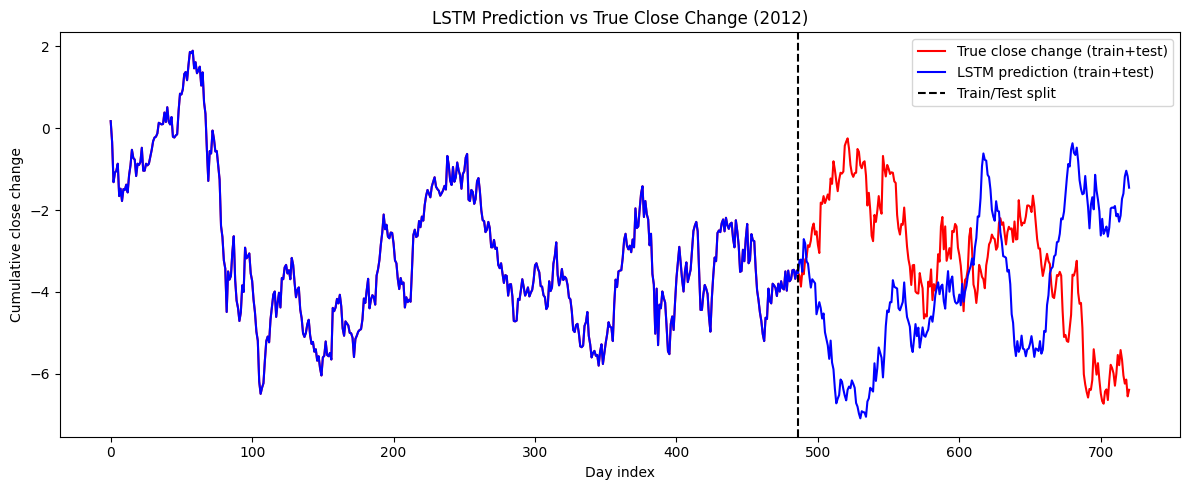

In [ ]:
mu, sigma = train_dataset.get_zscore_params()
preds_inv = np.array(preds) * sigma + mu
train_targets = []
for _, y in DataLoader(train_dataset, batch_size=1, shuffle=False):
    train_targets.append(y.squeeze(0).item())
train_targets = np.array(train_targets)
train_targets_inv = train_targets * sigma + mu

full_pred = np.concatenate([train_targets_inv, preds_inv])
full_true = np.concatenate([train_targets_inv, np.array(targets) * sigma + mu])

full_pred_curve = np.cumsum(full_pred)
full_true_curve = np.cumsum(full_true)

plt.figure(figsize=(12,5))
plt.plot(full_true_curve, c="r", label="True close change (train+test)")
plt.plot(full_pred_curve, c="b", label="LSTM prediction (train+test)")
plt.axvline(len(train_targets_inv)-1, color='k', linestyle='--', label='Train/Test split')
plt.title(f"LSTM Prediction vs True Close Change ({test_year[0]})")
plt.xlabel("Day index")
plt.ylabel("Cumulative close change")
plt.legend()
plt.tight_layout()
plt.show()

## Run on whole dataset

In [ ]:
years = np.arange(2006, 2018)
history_length = 15
rnn_results = []
dataloader = CSVDataLoader('data/MSFT_2006-01-01_to_2018-01-01.csv')
print("Sliding window results:")
for i in range(len(years) - 2):
    train_years = [years[i], years[i+1]]
    test_year = [years[i+2]]

    X_train, X_test = dataloader.split_by_year(train_years, test_year)
    train_dataset = StockTorchDataset(X_train, zscore_params=None, history=history_length)
    test_dataset = StockTorchDataset(X_test, zscore_params=train_dataset.get_zscore_params(), history=history_length)
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # Model, optimizer, loss
    input_size = history_length + 1 + 22  # history + today_change + features
    hidden_size = 32
    num_layers = 2
    rnn_type = "customLSTM" # Choose one from: "RNN", "LSTM", "GRU", "cutomLSTM"
    model = FinallModel(input_size=input_size, hidden_size=hidden_size, rnn_type=rnn_type, num_layers=num_layers)
    # model = SimpleLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    criterion = nn.L1Loss()

    # Train model
    train_mae = train(model=model, dataloader=train_loader, optimizer=optimizer, loss_fn=criterion, total_epochs=40, accum_steps=8)

    # Evaluate model
    preds, targets, test_mae = evaluate(model=model, dataloader=test_loader, loss_fn=criterion)
    print(f"Train years: {train_years}, Test year: {test_year} | Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")

Sliding window results:


Train years: [2006, 2007], Test year: [2008] | Train MAE: 0.3429, Test MAE: 1.5424


Train years: [2007, 2008], Test year: [2009] | Train MAE: 0.2897, Test MAE: 0.6526


Train years: [2008, 2009], Test year: [2010] | Train MAE: 0.2942, Test MAE: 0.5744


Train years: [2009, 2010], Test year: [2011] | Train MAE: 0.3395, Test MAE: 0.7384


Train years: [2010, 2011], Test year: [2012] | Train MAE: 0.3214, Test MAE: 0.9522


Train years: [2011, 2012], Test year: [2013] | Train MAE: 0.3510, Test MAE: 1.1704


Train years: [2012, 2013], Test year: [2014] | Train MAE: 0.2970, Test MAE: 1.0454


Train years: [2013, 2014], Test year: [2015] | Train MAE: 0.2917, Test MAE: 1.2791


Train years: [2014, 2015], Test year: [2016] | Train MAE: 0.3321, Test MAE: 0.9517


Train years: [2015, 2016], Test year: [2017] | Train MAE: 0.2985, Test MAE: 0.8058


In [ ]:
# (Sorry for this:))) -- 80 epochs

years = np.arange(2006, 2018)
history_length = 15
rnn_results = []
dataloader = CSVDataLoader('data/MSFT_2006-01-01_to_2018-01-01.csv')
print("Sliding window results:")
for i in range(len(years) - 2):
    train_years = [years[i], years[i+1]]
    test_year = [years[i+2]]

    X_train, X_test = dataloader.split_by_year(train_years, test_year)
    train_dataset = StockTorchDataset(X_train, zscore_params=None, history=history_length)
    test_dataset = StockTorchDataset(X_test, zscore_params=train_dataset.get_zscore_params(), history=history_length)
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # Model, optimizer, loss
    input_size = history_length + 1 + 22  # history + today_change + features
    hidden_size = 32
    num_layers = 2
    rnn_type = "customLSTM" # Choose one from: "RNN", "LSTM", "GRU", "cutomLSTM"
    model = FinallModel(input_size=input_size, hidden_size=hidden_size, rnn_type=rnn_type, num_layers=num_layers)
    # model = SimpleLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    criterion = nn.L1Loss()

    # Train model
    train_mae = train(model=model, dataloader=train_loader, optimizer=optimizer, loss_fn=criterion, total_epochs=80, accum_steps=8)

    # Evaluate model
    preds, targets, test_mae = evaluate(model=model, dataloader=test_loader, loss_fn=criterion)
    print(f"Train years: {train_years}, Test year: {test_year} | Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")

Sliding window results:


Train years: [2006, 2007], Test year: [2008] | Train MAE: 0.2010, Test MAE: 1.6518


Train years: [2007, 2008], Test year: [2009] | Train MAE: 0.1695, Test MAE: 0.8143


Train years: [2008, 2009], Test year: [2010] | Train MAE: 0.1520, Test MAE: 0.6319


Train years: [2009, 2010], Test year: [2011] | Train MAE: 0.1649, Test MAE: 0.9549


Train years: [2010, 2011], Test year: [2012] | Train MAE: 0.1850, Test MAE: 1.0805


Train years: [2011, 2012], Test year: [2013] | Train MAE: 0.1725, Test MAE: 1.1887


Train years: [2012, 2013], Test year: [2014] | Train MAE: 0.1651, Test MAE: 1.1033


Train years: [2013, 2014], Test year: [2015] | Train MAE: 0.1483, Test MAE: 1.4347


Train years: [2014, 2015], Test year: [2016] | Train MAE: 0.1794, Test MAE: 0.9712


Train years: [2015, 2016], Test year: [2017] | Train MAE: 0.1603, Test MAE: 0.8897
